In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import glob, dill, sys, os

import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
from matplotlib import rc
rc('text', usetex=True)

import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
import jax.random as random
from numpyro.infer import init_to_value

In [47]:
def model(x, y, xmin, xmax, xb_lower=3., xb_upper=30., xd_lower=1., xd_upper=100.):
    lnxmin, lnxmax = jnp.log(xmin), jnp.log(xmax)
    lnxmodel = numpyro.sample("lnxmodel", dist.Uniform(lnxmin, lnxmax), sample_shape=(len(x),))
    lnxsigma = numpyro.sample("lnxsigma", dist.HalfNormal(scale=0.1))
    numpyro.sample("obsx", dist.Normal(loc=lnxmodel, scale=lnxsigma), obs=jnp.log(x))
    xmodel = numpyro.deterministic("xmodel", jnp.exp(lnxmodel))
    xsigma = numpyro.deterministic("xsigma", jnp.exp(lnxsigma))

    power_short = numpyro.sample("power_short", dist.Normal(loc=0, scale=0.05))
    power_long = numpyro.sample("power_long", dist.Normal(loc=0, scale=5))
    lnp_break = numpyro.sample("lnp_break", dist.Uniform(jnp.log(xb_lower), jnp.log(xb_upper)))
    p_break = numpyro.deterministic("p_break", jnp.exp(lnp_break))
    R_break = numpyro.sample("R_break", dist.LogNormal(jnp.log(1e4), 1))

    def func(x, p_break, R_break):
        return jnp.where(x < p_break, R_break * (x/p_break)**power_short, R_break * (x/p_break)**power_long)

    rmodel = numpyro.deterministic("rmodel", func(xmodel, p_break, R_break))
    logrmodel = numpyro.deterministic("logrmodel", jnp.log(rmodel))
    logrsigma = numpyro.sample("logrsigma", dist.HalfNormal(scale=1.))
    numpyro.sample("obsy", dist.Normal(loc=logrmodel, scale=logrsigma), obs=jnp.log(y))

    xdense = numpyro.deterministic("xmodeldense", jnp.logspace(jnp.log(xd_lower), jnp.log(xd_upper), 1000, base=jnp.e))
    numpyro.deterministic("logrmodeldense", jnp.log(func(xdense, p_break, R_break)))

In [48]:
d = pd.read_csv("sample_clean_tau.csv")

In [49]:
dt = 150
tbins = np.arange(4000, 6500, dt)

In [50]:
for i in range(len(tbins)-1):
    tl, tu = tbins[i], tbins[i+1]
    idx = (d.teff>tl) & (d.teff<tu) #& (d.logg>logg_threshold)
    pobs = np.array(d[idx].Prot)
    print (tl, tu, np.percentile(pobs, [5, 10, 50, 90, 95]))

4000 4150 [10.3922 12.4386 23.761  39.696  43.0758]
4150 4300 [11.8288 12.6654 24.729  37.2234 40.0704]
4300 4450 [10.594  11.9665 24.4655 39.6155 42.69  ]
4450 4600 [ 9.7415 11.6448 23.9705 36.13   39.4255]
4600 4750 [10.24125 11.2325  24.6135  36.5755  38.0495 ]
4750 4900 [ 8.2715  9.6345 21.698  34.1575 36.906 ]
4900 5050 [ 8.21695  9.3905  22.5985  32.1233  34.30365]
5050 5200 [ 7.65085  9.5017  23.0315  32.8349  35.06465]
5200 5350 [ 7.0075  8.0952 20.549  30.6942 32.5819]
5350 5500 [ 5.9175  7.5714 19.168  28.0618 29.5266]
5500 5650 [ 5.8566  7.3476 18.658  24.8798 26.189 ]
5650 5800 [ 4.334    6.0435  15.16    21.011   22.68275]
5800 5950 [ 3.354   4.8026 12.767  18.0342 19.6812]
5950 6100 [ 2.52105  4.3848  10.847   15.4933  20.06225]
6100 6250 [ 1.87675  2.7945   7.5405  12.623   16.266  ]
6250 6400 [ 1.4138  1.8466  4.907  14.6226 18.689 ]


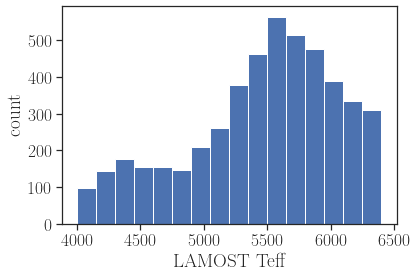

In [51]:
plt.xlabel("LAMOST Teff")
plt.ylabel("count")
plt.hist(d.teff, bins=tbins);

In [52]:
rnlabel = "variability amplitude $R_\mathrm{per}$\n normalized by Kepler photometric precision"
rlabel = "variability amplitude $R_\mathrm{per}$ (ppm)"
pnlabel = r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$ (Lehtinen et al. 2021 scale)"
dtlabel = 'empirical detection threshold'
tefflabel = 'LAMOST $T_\mathrm{eff}$ (K)'
protlabel = 'rotation period $P_\mathrm{rot}$ (days)'

## Fitting Rper vs Ro

In [53]:
resdir = 'plfitro_results_t%d_l21/'%dt

In [54]:
resdir

'plfitro_results_t150_l21/'

In [55]:
resume = True

In [56]:
scale = np.median(d['Pnorm'] / d['Pnorml21'])

In [57]:
d['Pnorm'] = d['Pnorml21']

In [58]:
scale

2.608396970920248

plfitro_results_t150_l21/teff4000-4150
x data min and max: 0.09212181262621572 0.3819579725034785
xb limits: 0.19168861395495293 0.3819579725034785
plfitro_results_t150_l21/teff4150-4300
x data min and max: 0.11779275648812504 0.3979402534974904
xb limits: 0.19168861395495293 0.3979402534974904
plfitro_results_t150_l21/teff4300-4450
x data min and max: 0.11392710033246164 0.47321370744220287
xb limits: 0.19168861395495293 0.47321370744220287
plfitro_results_t150_l21/teff4450-4600
x data min and max: 0.11669448781568821 0.4826273556412163
xb limits: 0.19168861395495293 0.4826273556412163
plfitro_results_t150_l21/teff4600-4750
x data min and max: 0.13596962829556092 0.5021964995617463
xb limits: 0.19168861395495293 0.5021964995617463
plfitro_results_t150_l21/teff4750-4900
x data min and max: 0.11702173733693601 0.5139276797492539
xb limits: 0.19168861395495293 0.5139276797492539
plfitro_results_t150_l21/teff4900-5050
x data min and max: 0.12513716866568964 0.5192447392545202
xb limits: 0

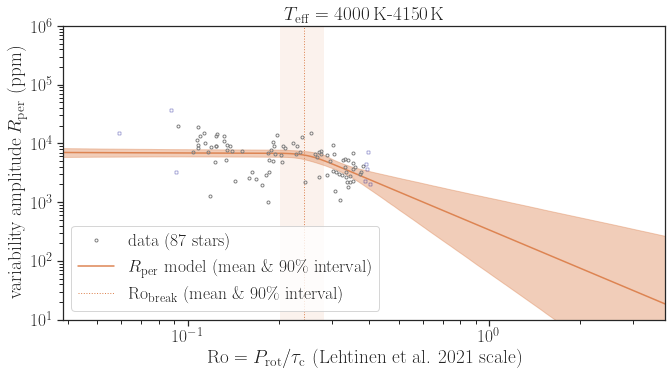

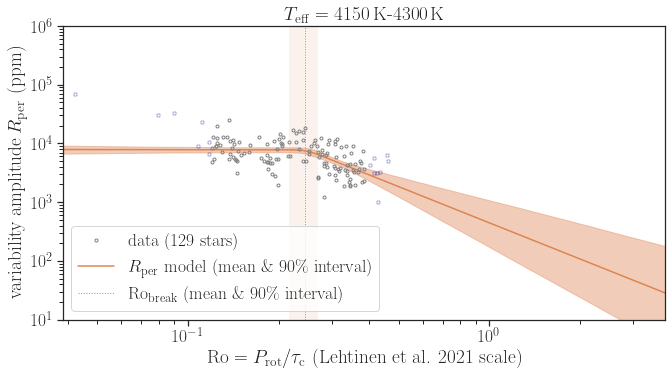

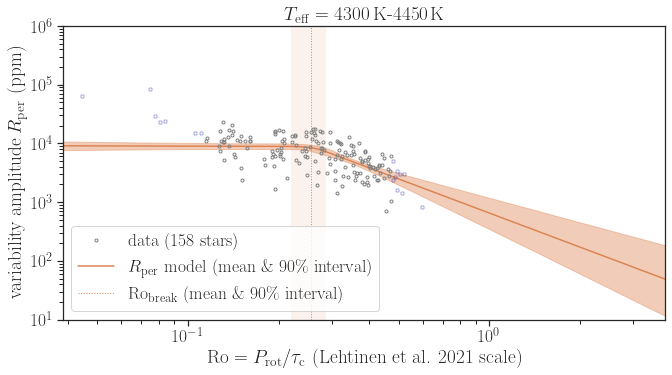

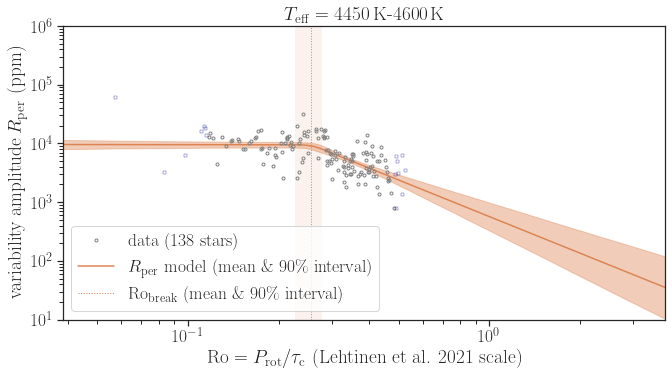

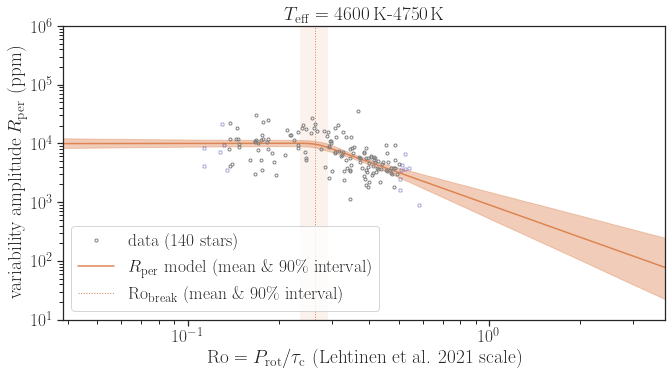

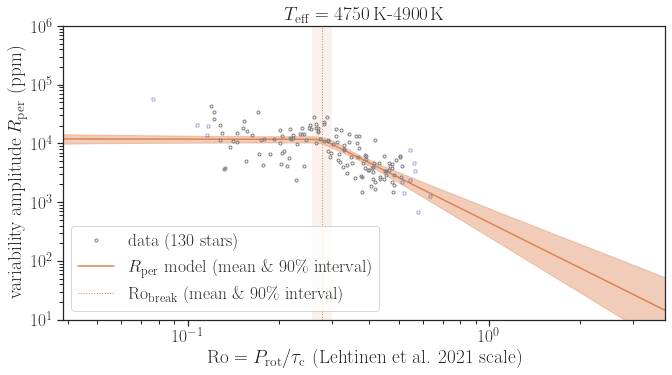

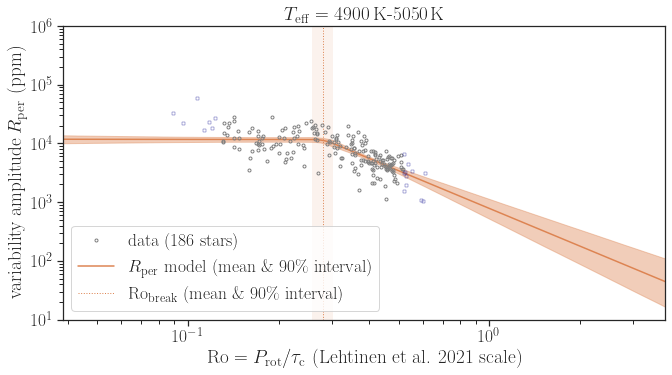

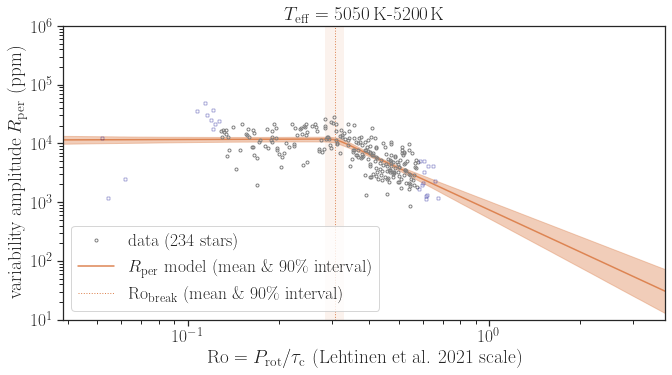

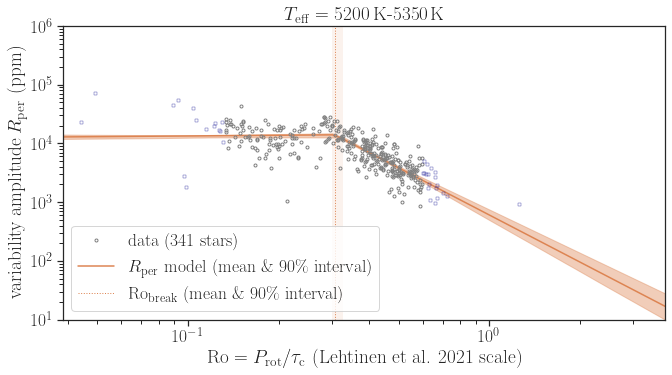

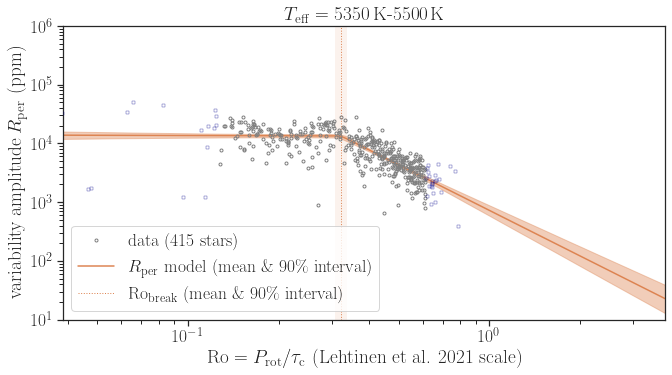

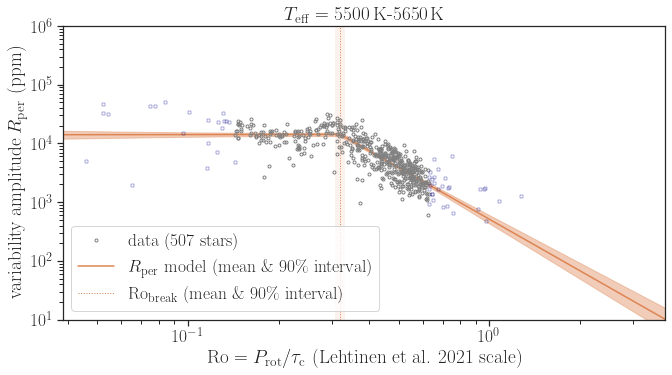

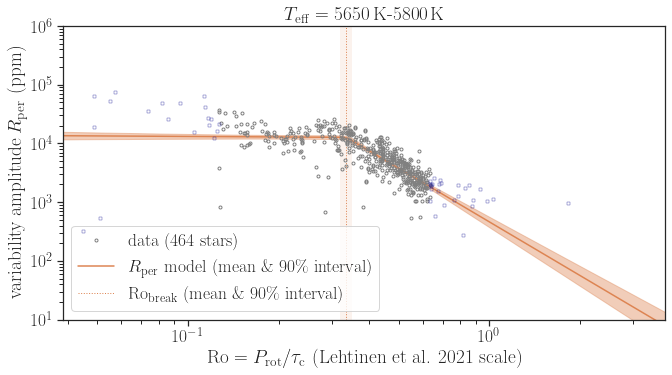

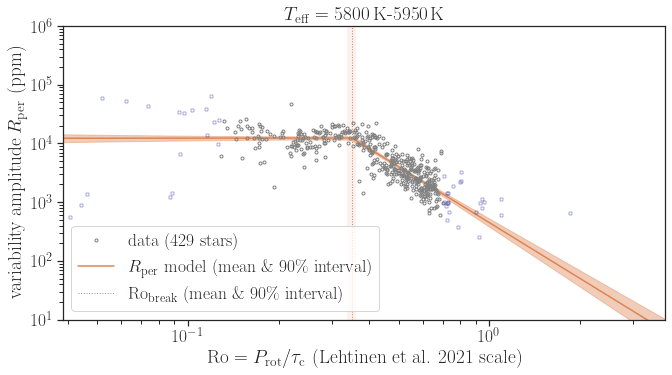

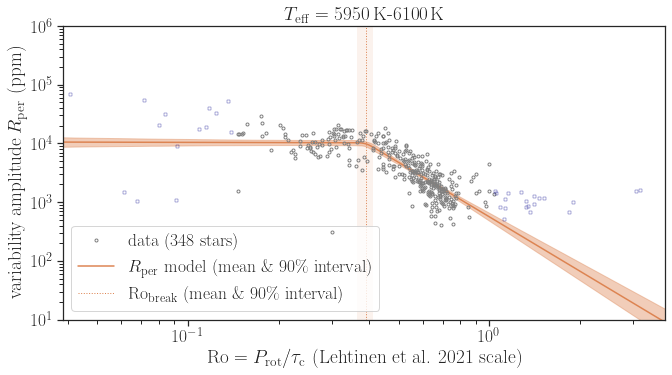

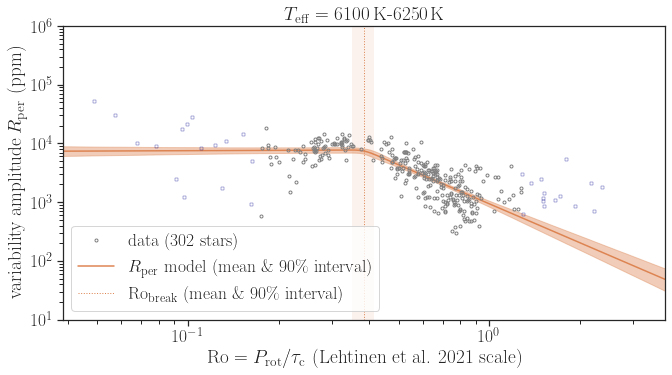

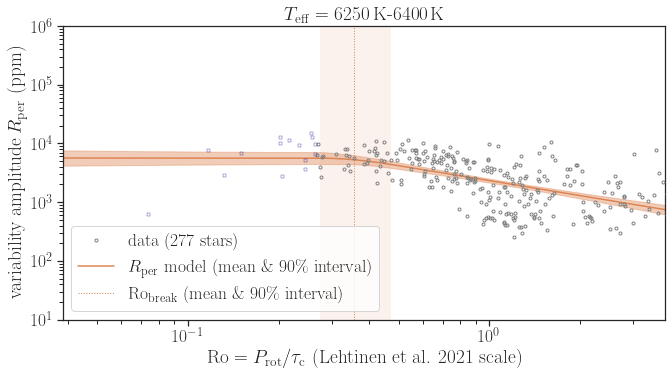

In [59]:
for i in range(len(tbins)-1):
    tl, tu = tbins[i], tbins[i+1]

    outname = resdir+"teff%d-%d"%(tl, tu)
    print (outname)    

    idx = (d.teff>tl) & (d.teff<tu) #& (d.logg>logg_threshold)
    pmin, pmax = np.percentile(d[idx].Pnorm, [5, 95])
    print ("x data min and max:", pmin, pmax)
    print ("xb limits:", np.fmax(pmin, 0.5/scale), np.fmin(pmax, 2./scale))
    
    idxp = (pmin<d.Pnorm) & (d.Pnorm<pmax)
    pobs, robs = jnp.array(d[idx&idxp].Pnorm), jnp.array(d[idx&idxp].Rper)
    pobs_out, robs_out = d[idx&(~idxp)].Pnorm, d[idx&(~idxp)].Rper
    
    filename = outname + "_mcmc.pkl"
    if os.path.exists(filename) and resume:
        mcmc = dill.load(open(filename, 'rb'))   
        #mcmc.print_summary()
    else:   
        init_strategy = init_to_value(values={"lnxmodel": jnp.log(pobs)})
        kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)
        nw, ns = 1000, 5000
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, pobs, robs, pmin, pmax,
                 xb_lower=np.fmax(pmin, 0.5/scale), xb_upper=np.fmin(pmax, 2./scale),
                 #xb_lower=0.1, xb_upper=0.5,
                 xd_lower=0.1/scale, xd_upper=10/scale, extra_fields=('potential_energy',))
        mcmc.print_summary()
        with open(outname+"_mcmc.pkl", "wb") as f:
            dill.dump(mcmc, f)

    samples = mcmc.get_samples()

    pmod = jnp.mean(samples['xmodeldense'], axis=0)
    rmean = jnp.exp(jnp.mean(samples['logrmodeldense'], axis=0))
    r5, r95 = jnp.exp(jnp.percentile(samples['logrmodeldense'], q=jnp.array([5, 95]), axis=0))
    rsigmamean = jnp.mean(jnp.exp(samples['logrsigma']))
    pb, pbsd = jnp.mean(samples['p_break']), jnp.std(samples['p_break'])
    pb5, pb95 = jnp.percentile(samples['p_break'], q=jnp.array([5,95]))

    plt.figure(figsize=(12*0.9,6*0.9))
    plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    plt.ylim(1e1, 1e6)
    plt.xlim(0.1/scale, 10/scale)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rlabel)
    plt.xlabel(pnlabel)
    #idxd = (pobs>pmin) & (pobs<pmax)
    if tu-tl>1000:
        mew=0.5
        plt.plot(pobs, robs, '.', color='gray', markersize=1, zorder=1000, alpha=0.8, label='data (%d stars)'%len(pobs))
        #plt.plot(pobs_out, robs_out, '.', color='gray', markersize=1, zorder=1000, alpha=0.4)
        plt.plot(pobs_out, robs_out, 's', color='darkblue', zorder=1000, alpha=0.8, markersize=3, mfc='none', mew=0.4)
    else:
        mew=1.
        plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=mew, zorder=1000, label='data (%d stars)'%len(pobs))
        #plt.plot(pobs_out, robs_out, '.', color='gray', mfc='none', mew=mew, zorder=1000, alpha=0.7)
        plt.plot(pobs_out, robs_out, 's', color='darkblue', zorder=1000, alpha=0.8, markersize=3, mfc='none', mew=0.4)
    plt.plot(pmod, rmean, '-', color='C1', label='$R_\mathrm{per}$ model (mean \& 90\% interval)')
    plt.axvline(x=pb, color='C1', ls='dotted', lw=1, label='$\mathrm{Ro}_\mathrm{break}$ (mean \& 90\% interval)')
    plt.fill_betweenx(np.logspace(1,6,100), x1=pb5, x2=pb95, color='C1', lw=0, alpha=0.1)
    plt.fill_between(pmod, r5, r95, alpha=0.4, color='C1')
    plt.legend(loc='lower left')
    plt.savefig(outname+"_romodel.png", dpi=200, bbox_inches="tight")

In [60]:
resdir = 'plfitro_results_t%d_l21/'%dt

In [90]:
tbins_all = np.array([4000, 6250])
resume = True * 0
magcut = True

In [91]:
resdir

'plfitro_results_t150_l21/'

  0%|                                                                                                                           | 0/6000 [00:00<?, ?it/s]

plfitro_results_t150_l21/teff4000-6250
0.12343807510653548 0.7146492157665099


/Users/k_masuda/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)
sample: 100%|███████████████████████████████████████████████████████████| 6000/6000 [00:33<00:00, 177.13it/s, 127 steps of size 9.98e-02. acc. prob=0.93]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  10124.03    713.97  10098.71   8998.46  11299.26   4197.81      1.00
    lnp_break     -1.05      0.06     -1.05     -1.15     -0.95   4668.32      1.00
  lnxmodel[0]     -0.94      0.02     -0.94     -0.97     -0.92   7805.53      1.00
  lnxmodel[1]     -0.80      0.02     -0.80     -0.82     -0.77   5953.54      1.00
  lnxmodel[2]     -1.41      0.02     -1.41     -1.44     -1.39   6616.65      1.00
  lnxmodel[3]     -0.52      0.02     -0.52     -0.54     -0.49   8117.53      1.00
  lnxmodel[4]     -0.41      0.02     -0.41     -0.44     -0.39   4743.47      1.00
  lnxmodel[5]     -1.29      0.02     -1.29     -1.32     -1.26  10609.12      1.00
  lnxmodel[6]     -2.00      0.02     -2.00     -2.02     -1.97   7314.14      1.00
  lnxmodel[7]     -0.70      0.02     -0.70     -0.73     -0.67   8827.20      1.00
  lnxmodel[8]     -0.42      0.02     -0.42     -0.44     -0.39   4956.35  

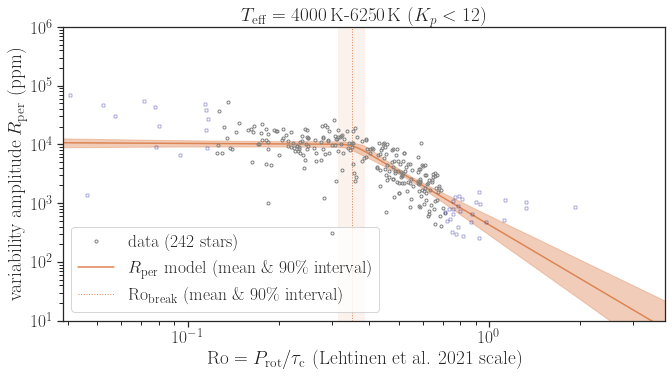

In [92]:
for i in range(len(tbins_all)-1):
    tl, tu = tbins_all[i], tbins_all[i+1]
    outname = resdir+"teff%d-%d"%(tl, tu)
    print (outname)    

    idx = (d.teff>tl) & (d.teff<tu) #& (d.logg>logg_threshold)
    pmin, pmax = np.percentile(d[idx].Pnorm, [5, 95])
    print (pmin, pmax)
    
    if magcut:
        idx &= (d.kepmag < 12)
        outname += "_kp12"
    
    idxp = (pmin<d.Pnorm) & (d.Pnorm<pmax)
    pobs, robs = jnp.array(d[idx&idxp].Pnorm), jnp.array(d[idx&idxp].Rper)
    pobs_out, robs_out = d[idx&(~idxp)].Pnorm, d[idx&(~idxp)].Rper
    
    filename = outname + "_mcmc.pkl"
    if os.path.exists(filename) and resume:
        mcmc = dill.load(open(filename, 'rb'))   
        mcmc.print_summary()
    else:   
        init_strategy = init_to_value(values={"lnxmodel": jnp.log(pobs)})
        kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)
        nw, ns = 1000, 5000 #// 5
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, pobs, robs, pmin, pmax,
                 xb_lower=np.fmax(pmin, 0.5/scale), xb_upper=np.fmin(pmax, 2./scale),
                 #xb_lower=0.1, xb_upper=0.5,
                 xd_lower=0.1/scale, xd_upper=10/scale, extra_fields=('potential_energy',))
        mcmc.print_summary()
        with open(outname+"_mcmc.pkl", "wb") as f:
            dill.dump(mcmc, f)

    samples = mcmc.get_samples()

    pmod = jnp.mean(samples['xmodeldense'], axis=0)
    rmean = jnp.exp(jnp.mean(samples['logrmodeldense'], axis=0))
    r5, r95 = jnp.exp(jnp.percentile(samples['logrmodeldense'], q=jnp.array([5, 95]), axis=0))
    rsigmamean = jnp.mean(jnp.exp(samples['logrsigma']))
    pb, pbsd = jnp.mean(samples['p_break']), jnp.std(samples['p_break'])
    pb5, pb95 = jnp.percentile(samples['p_break'], q=jnp.array([5,95]))

    plt.figure(figsize=(12*0.9,6*0.9))
    if 'kp12' in outname:
        plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$ ($K_p<12$)"%(tl, tu))
    else:
        plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    plt.ylim(1e1, 1e6)
    plt.xlim(0.1/scale, 10/scale)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rlabel)
    plt.xlabel(pnlabel)
    #idxd = (pobs>pmin) & (pobs<pmax)
    if tu-tl>1000 and len(pobs)>300:
        mew=0.5
        plt.plot(pobs, robs, '.', color='gray', markersize=1, zorder=1000, alpha=0.8, label='data (%d stars)'%len(pobs))
        #plt.plot(pobs_out, robs_out, '.', color='gray', markersize=1, zorder=1000, alpha=0.4)
        plt.plot(pobs_out, robs_out, 's', color='darkblue', zorder=1000, alpha=0.8, markersize=1, mfc='none', mew=0.4)
    else:
        mew=1.
        plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=mew, zorder=1000, label='data (%d stars)'%len(pobs))
        #plt.plot(pobs_out, robs_out, '.', color='gray', mfc='none', mew=mew, zorder=1000, alpha=0.7)
        plt.plot(pobs_out, robs_out, 's', color='darkblue', zorder=1000, alpha=0.8, markersize=3, mfc='none', mew=0.4)
    plt.plot(pmod, rmean, '-', color='C1', label='$R_\mathrm{per}$ model (mean \& 90\% interval)')
    plt.axvline(x=pb, color='C1', ls='dotted', lw=1, label='$\mathrm{Ro}_\mathrm{break}$ (mean \& 90\% interval)')
    plt.fill_betweenx(np.logspace(1,6,100), x1=pb5, x2=pb95, color='C1', lw=0, alpha=0.1)
    plt.fill_between(pmod, r5, r95, alpha=0.4, color='C1')
    plt.legend(loc='lower left')
    plt.savefig(outname+"_romodel.png", dpi=200, bbox_inches="tight")
    
    continue
    
    keys = ["R_break", "p_break", "power_long", "power_short", "logrsigma", "lnxsigma"]
    labels = ['Rb', 'Pb', 'pl', 'ps', 'logrsigma', 'logxsigma']
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
    fig = corner.corner(hyper, labels=labels, show_titles="%.2f")
    plt.savefig(outname+"_corner.png", dpi=200, bbox_inches="tight")

## residual

In [76]:
res = np.array(np.log10(robs) - jnp.mean(np.log10(samples['rmodel']), axis=0))

In [77]:
rnds = np.random.randn(int(1e7))*np.mean(samples['logrsigma'])*np.log10(np.e)

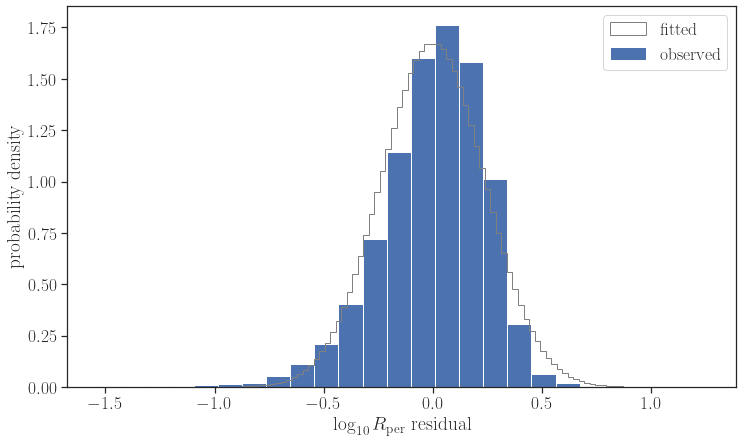

In [78]:
plt.figure(figsize=(12,7))
plt.xlabel("$\log_{10} R_\mathrm{per}$ residual")
plt.ylabel("probability density")
plt.hist(np.array(rnds), bins=100, density=True, histtype='step', lw=1, color='gray', label='fitted')
plt.hist(res, bins=20, density=True, label='observed')
plt.legend(loc='best')

### FeH dependence

In [79]:
fehobs = d[idx&idxp].feh
meansigma = np.mean(samples['logrsigma'])*np.log10(np.e)

In [80]:
from scipy.stats import pearsonr

In [81]:
idxf = np.abs(fehobs)<0.5
print ("Pearson R:", pearsonr(fehobs[idxf], res[idxf]))
a, b = np.polyfit(fehobs[idxf], res[idxf], deg=1)
print (a, b)

Pearson R: (0.3732399429336361, 7.521623035089651e-132)
0.5237101293878555 -0.01607895859047448


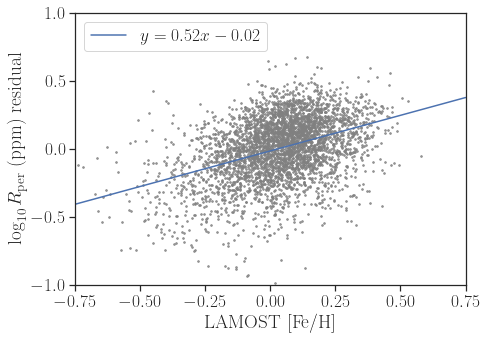

In [82]:
plt.figure(figsize=(7,5))
plt.ylim(-1, 1)
plt.xlim(-0.75, 0.75)
plt.xlabel("LAMOST [Fe/H]")
plt.ylabel("$\log_{10}R_\mathrm{per}$ (ppm) residual")
plt.plot(fehobs, res, '.', markersize=3, color='gray', mfc='none')
feh0 = np.linspace(-0.75, 0.75, 100)
plt.plot(feh0, a*feh0+b, label='$y=%.2fx-%.2f$'%(a, -b))
plt.legend(loc='upper left')
plt.savefig(resdir+"feh.png", dpi=200, bbox_inches='tight')